Epoch 1/200


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.1579 - val_loss: 0.2462
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0748 - val_loss: 0.1100
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0519 - val_loss: 0.0747
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0587 - val_loss: 0.0937
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0368 - val_loss: 0.1226
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0483 - val_loss: 0.1364
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0550 - val_loss: 0.1335
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0495 - val_loss: 0.1199
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0476 - val_loss: 0.0943
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0400 - val_loss: 0.0762
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0406 - val_loss: 0.0782
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0499 - val_loss: 0.0954


C:\Users\Aditya\AppData\Local\Temp\ipykernel_27828\1124809948.py:100: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=revenue_data.index[-1], periods=9, freq="Q")[1:]


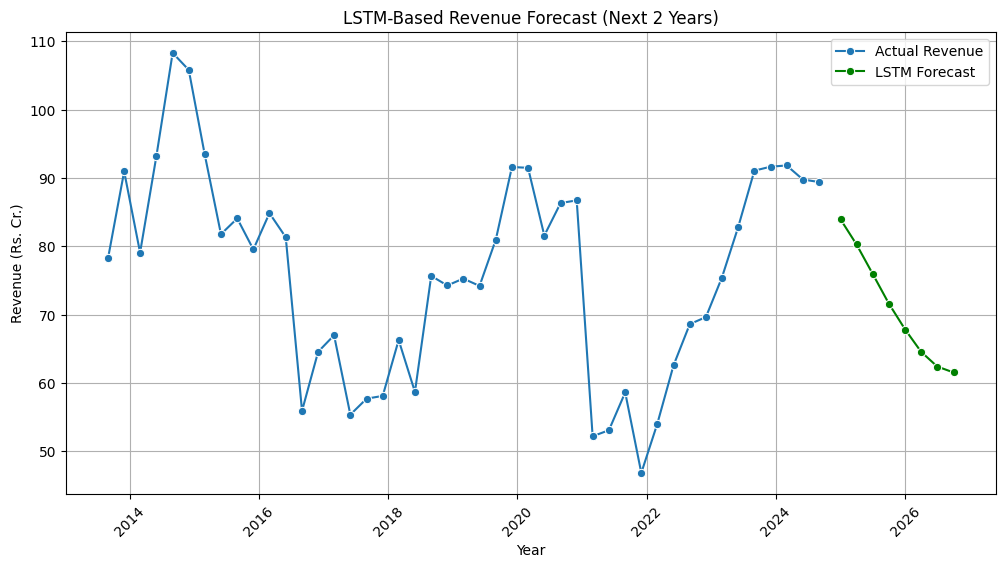

array([[83.930885],
       [80.272736],
       [75.98541 ],
       [71.60623 ],
       [67.82571 ],
       [64.571976],
       [62.419804],
       [61.55138 ]], dtype=float32)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Load the dataset
file_path = r"C:\Users\Aditya\Desktop\FyPro\Companies\IT Services & Consulting\3i Infotech Ltd\Pruned_Excel\Final_Parameters\3i Infotech Ltd_Semi_Semi_Final.xlsx"

df = pd.read_excel(file_path, sheet_name="Quarterly")

# Extract and preprocess date column
month_mapping = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
                 "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}

df["Month"] = df.iloc[:, 0].str[:3]  # First 3 letters (Month)
df["Year"] = "20" + df.iloc[:, 0].str[4:6]  # Extract last 2 digits of the year
df["Month"] = df["Month"].map(month_mapping)

# Convert to DateTime format
df["Quarter"] = pd.to_datetime(df["Year"] + "-" + df["Month"] + "-01")
df.set_index("Quarter", inplace=True)

# Select revenue column
revenue_data = df["Net sales/income from operations"].dropna()

# Normalize the revenue data
scaler = MinMaxScaler(feature_range=(0, 1))
revenue_scaled = scaler.fit_transform(revenue_data.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 8  # Use past 8 quarters (2 years) for prediction
X, y = create_sequences(revenue_scaled, seq_length)

# Split into train & test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# Convert predictions back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Calculate Accuracy Metrics
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100  # Convert to percentage
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))  # Root Mean Squared Error

# Print Accuracy Results
print(f"📊 Model Accuracy (100 - MAPE): {100 - mape:.2f}%")
print(f"📉 RMSE: {rmse:.2f}")

# Forecast the next 8 quarters
last_sequence = revenue_scaled[-seq_length:].reshape(1, seq_length, 1)
forecast_scaled = []

for _ in range(8):
    pred = model.predict(last_sequence)
    forecast_scaled.append(pred[0][0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0][0]]]], axis=1)

# Convert back to original scale
forecast_lstm = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=revenue_data.index[-1], periods=9, freq="Q")[1:]

# Plot actual vs forecasted revenue
plt.figure(figsize=(12, 6))
sns.lineplot(x=revenue_data.index, y=revenue_data.values, marker="o", label="Actual Revenue")
sns.lineplot(x=future_dates, y=forecast_lstm.flatten(), marker="o", color="green", label="LSTM Forecast")
plt.xlabel("Year")
plt.ylabel("Revenue (Rs. Cr.)")
plt.title("LSTM-Based Revenue Forecast (Next 2 Years)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Display forecasted values
forecast_lstm


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Load the dataset
file_path = r"C:\Users\Aditya\Downloads\net_profit_data.xlsx"
df = pd.read_excel(file_path)

# Convert Quarter format to datetime
month_mapping = {"Q1": "03", "Q2": "06", "Q3": "09", "Q4": "12"}
df["Year"] = "20" + df["Quarters"].str[-2:]  # Extract last 2 digits of the year
df["Month"] = df["Quarters"].str[:2].map(month_mapping)
df["Date"] = pd.to_datetime(df["Year"] + "-" + df["Month"] + "-01", errors="coerce")

# Drop invalid dates and set index
df.drop(columns=["Year", "Month", "Quarters"], inplace=True)
df.set_index("Date", inplace=True)

# Select net profit data for "3i Infotech Ltd"
net_profit_data = df["3i Infotech Ltd"].dropna()

# Normalize the net profit data
scaler = MinMaxScaler(feature_range=(0, 1))
profit_scaled = scaler.fit_transform(net_profit_data.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 8  # Use past 8 quarters (2 years) for prediction
X, y = create_sequences(profit_scaled, seq_length)

# Split into train & test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# Convert predictions back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Calculate Accuracy Metrics
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100  # Convert to percentage
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))  # Root Mean Squared Error

# Print Accuracy Results
print(f"📊 Model Accuracy (100 - MAPE): {100 - mape:.2f}%")
print(f"📉 RMSE: {rmse:.2f}")

# Forecast the next 8 quarters
last_sequence = profit_scaled[-seq_length:].reshape(1, seq_length, 1)
forecast_scaled = []

for _ in range(8):
    pred = model.predict(last_sequence)
    forecast_scaled.append(pred[0][0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0][0]]]], axis=1)

# Convert back to original scale
forecast_lstm = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=net_profit_data.index[-1], periods=9, freq="Q")[1:]

# Plot actual vs forecasted net profit
plt.figure(figsize=(12, 6))
sns.lineplot(x=net_profit_data.index, y=net_profit_data.values, marker="o", label="Actual Net Profit")
sns.lineplot(x=future_dates, y=forecast_lstm.flatten(), marker="o", color="green", label="LSTM Forecast")
plt.xlabel("Year")
plt.ylabel("Net Profit (Rs. Cr.)")
plt.title("LSTM-Based Net Profit Forecast for 3i Infotech Ltd (Next 2 Years)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Display forecasted values
forecast_lstm


In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Load the dataset
file_path = r"C:\Users\Aditya\Downloads\net_profit_data.xlsx"# Update with actual file path
df = pd.read_excel(file_path)

# Convert Quarter format to datetime
month_mapping = {"Q1": "03", "Q2": "06", "Q3": "09", "Q4": "12"}
df["Year"] = "20" + df["Quarters"].str[-2:]  # Extract last 2 digits of the year
df["Month"] = df["Quarters"].str[:2].map(month_mapping)
df["Date"] = pd.to_datetime(df["Year"] + "-" + df["Month"] + "-01", errors="coerce")

# Remove NaT values before setting the index
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)

# Debugging step: Print column names to check if "3i Infotech Ltd" exists
print("📊 Available columns:", df.columns)

# Check if "3i Infotech Ltd" exists
if "3i Infotech Ltd" not in df.columns:
    raise ValueError("🚨 Error: '3i Infotech Ltd' column not found in the dataset!")

# Drop missing values and select net profit data
net_profit_data = df["3i Infotech Ltd"].dropna()

# Ensure we have data before proceeding
if net_profit_data.empty:
    raise ValueError("🚨 Error: No valid data found for '3i Infotech Ltd'. Check your input file.")

# Ensure the last date is valid before forecasting
if pd.isna(net_profit_data.index[-1]):
    raise ValueError("🚨 Error: Last date in the dataset is NaT. Check your input data.")

# Normalize the net profit data
scaler = MinMaxScaler(feature_range=(0, 1))
profit_scaled = scaler.fit_transform(net_profit_data.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 8  # Use past 8 quarters (2 years) for prediction
X, y = create_sequences(profit_scaled, seq_length)

# Ensure we have enough data for training
if len(X) == 0 or len(y) == 0:
    raise ValueError("🚨 Error: Not enough data for LSTM training. Ensure at least 8 quarters of data exist.")

# Split into train & test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# Convert predictions back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Calculate Accuracy Metrics
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100  # Convert to percentage
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))  # Root Mean Squared Error

# Print Accuracy Results
print(f"📊 Model Accuracy (100 - MAPE): {100 - mape:.2f}%")
print(f"📉 RMSE: {rmse:.2f}")

# Forecast the next 8 quarters
last_sequence = profit_scaled[-seq_length:].reshape(1, seq_length, 1)
forecast_scaled = []

for _ in range(8):
    pred = model.predict(last_sequence)
    forecast_scaled.append(pred[0][0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0][0]]]], axis=1)

# Convert back to original scale
forecast_lstm = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Generate future dates safely
future_dates = pd.date_range(start=net_profit_data.index[-1], periods=9, freq="Q")[1:]

# Plot actual vs forecasted net profit
plt.figure(figsize=(12, 6))
sns.lineplot(x=net_profit_data.index, y=net_profit_data.values, marker="o", label="Actual Net Profit")
sns.lineplot(x=future_dates, y=forecast_lstm.flatten(), marker="o", color="green", label="LSTM Forecast")
plt.xlabel("Year")
plt.ylabel("Net Profit (Rs. Cr.)")
plt.title("LSTM-Based Net Profit Forecast for 3i Infotech Ltd (Next 2 Years)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Display forecasted values
forecast_lstm


📊 Available columns: Index(['Quarters', '3i Infotech Ltd', 'Adroit Infotech Ltd',
       'AION-TECH SOLUTIONS Ltd', 'Year', 'Month'],
      dtype='object')


ValueError: 🚨 Error: No valid data found for '3i Infotech Ltd'. Check your input file.